# AirBnB : Part 2, Model Selection ALL CITIES

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,RandomizedLogisticRegression

from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix,classification_report,roc_curve,auc
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.grid_search import GridSearchCV


from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from xgboost import XGBClassifier
from utils import rstr,distance

import pickle

airBColor= '#ff5a5f'
airBColor2= '#008489'

/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationW

In [2]:
df = pd.read_csv('../../data/all_cities/dataset_for_modeling.csv')
cities = df.city
cities.value_counts()

paris        14343
roma          8367
london        6795
barcelona     4525
madrid        4420
berlin        3443
venice        2962
vienna        2838
amsterdam     2616
athens        2294
brussels      1830
dublin        1393
geneva         606
antwerp        447
Name: city, dtype: int64

In [3]:
features_RLR =  pickle.load(open('best_features/features_RLR.p', 'rb'))
features_Kbest_chi2=  pickle.load(open('best_features/features_Kbest_chi2.p', 'rb'))
features_Kbest_fclass=  pickle.load(open('best_features/features_Kbest_fclass.p', 'rb'))
features_XBOOST =  pickle.load(open('best_features/XGB_features.p', 'rb'))
all_features = pickle.load(open('best_features/best_features.p', 'rb'))

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features_ALL = df.select_dtypes(include=numerics).columns.tolist()

In [4]:
df.shape

(56879, 198)

In [5]:
df=df[['multihost']+ all_features]

In [6]:
df.shape

(56879, 197)

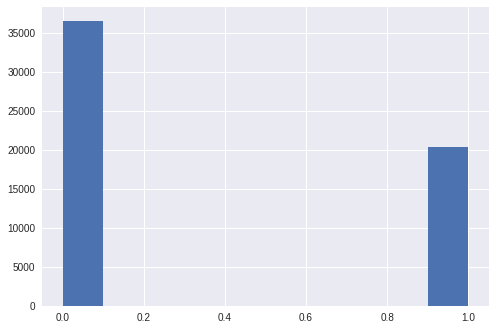

In [7]:
df.multihost.hist()

### Filter on listings with high reviews number

### Fill the missing data

In [8]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


## Linear Model and R-squared

In [9]:
TARGET_CLASSIFICATION ='multihost'
y = df[TARGET_CLASSIFICATION]

X = df.drop(TARGET_CLASSIFICATION,axis=1)

### Train test split

In [10]:
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [11]:
rebalanced_index = balanced_subsample(y)

In [12]:
X,y = X.loc[rebalanced_index],y.loc[rebalanced_index]

In [13]:
y.value_counts()

1    20385
0    20385
Name: multihost, dtype: int64

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

print y_test.value_counts()

1    4131
0    4023
Name: multihost, dtype: int64


### Filter test set on Berlin listings

In [15]:
berlin_index = cities[cities=='berlin'].index
print len(berlin_index)

berlin_test_index = y_test.index.intersection(berlin_index)

print berlin_test_index[:5]

3443
Int64Index([13184, 11931, 11671, 11705, 11477], dtype='int64')
Int64Index([13184, 11931, 11671, 11705, 11477], dtype='int64')


### Logistic Regression

In [16]:
clf = LogisticRegression(C=1e5)
clf.fit(X_train.values,y_train.values)
prediction = clf.predict(X_test)
prediction_berlin =  clf.predict(X_test.loc[berlin_test_index])


cv_scores =cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print '\n'
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
print '\n'
print confusion_matrix(y_test,prediction)
print '\n'
print classification_report(y_test,prediction)

print('\n')
print classification_report(y_test.loc[berlin_test_index],prediction_berlin)



Accuracy: 0.78 (+/- 0.02)


[[3056  967]
 [ 921 3210]]


             precision    recall  f1-score   support

          0       0.77      0.76      0.76      4023
          1       0.77      0.78      0.77      4131

avg / total       0.77      0.77      0.77      8154



             precision    recall  f1-score   support

          0       0.81      0.91      0.86       303
          1       0.76      0.58      0.65       153

avg / total       0.79      0.80      0.79       456



### Random Forest

In [17]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
prediction_berlin =  clf.predict(X_test.loc[berlin_test_index])


cv_scores =cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print '\n'
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
print '\n'
print confusion_matrix(y_test,prediction)
print '\n'
print classification_report(y_test,prediction)

print('\n')
print classification_report(y_test.loc[berlin_test_index],prediction_berlin)



Accuracy: 0.68 (+/- 0.02)


[[3124  899]
 [1336 2795]]


             precision    recall  f1-score   support

          0       0.70      0.78      0.74      4023
          1       0.76      0.68      0.71      4131

avg / total       0.73      0.73      0.73      8154



             precision    recall  f1-score   support

          0       0.76      0.90      0.82       303
          1       0.69      0.44      0.54       153

avg / total       0.74      0.75      0.73       456



### XGB

In [18]:
params = {
    'max_depth':12,
    'min_child_weight':8,
    'learning_rate' :0.5,
    'gamma':0.0,
    'n_estimators':100
}

print params

clf = XGBClassifier(**params)

#best_clf = cv_optimize(clf,params,X_train,y_train)
clf.fit(X_train,y_train)
print(clf)



{'n_estimators': 100, 'gamma': 0.0, 'learning_rate': 0.5, 'max_depth': 12, 'min_child_weight': 8}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.5, max_delta_step=0, max_depth=12,
       min_child_weight=8, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [25]:
prediction = clf.predict_proba(X_test)

prediction_berlin =  clf.predict_proba(X_test.loc[berlin_test_index])



print confusion_matrix(y_test,prediction[:,1]>.5)

print classification_report(y_test,prediction[:,1]>.5)
print '\n'

print classification_report(y_test[berlin_test_index],prediction_berlin[:,1]>.5)

[[3178  845]
 [ 861 3270]]
             precision    recall  f1-score   support

          0       0.79      0.79      0.79      4023
          1       0.79      0.79      0.79      4131

avg / total       0.79      0.79      0.79      8154



             precision    recall  f1-score   support

          0       0.85      0.92      0.88       303
          1       0.81      0.67      0.74       153

avg / total       0.84      0.84      0.83       456



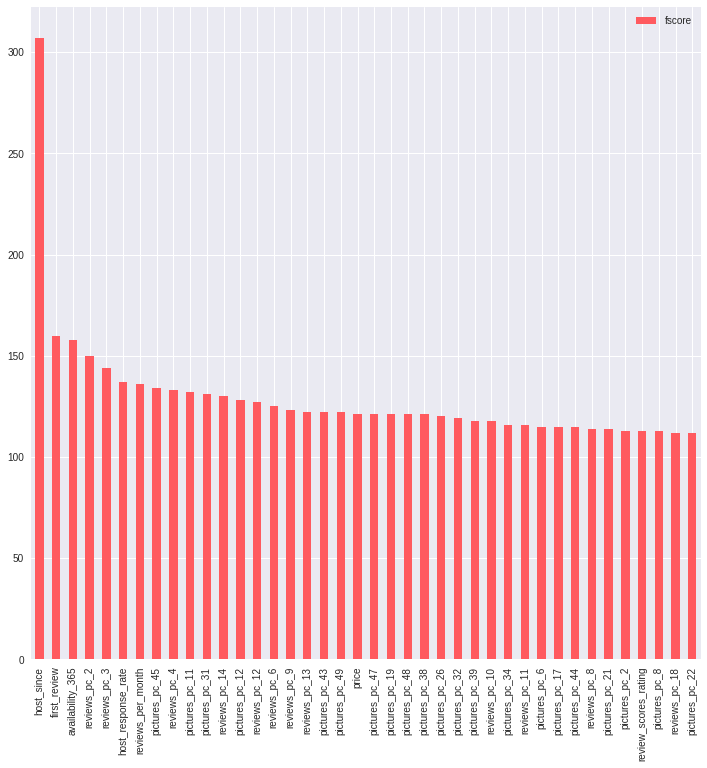

In [20]:
features_weights = pd.DataFrame.from_dict(clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(40).plot(kind='bar',title='',color=airBColor,figsize=(12,12))

### Plot ROC Curve

In [53]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=200, proba=True, skip=1):
    initial=False
    if not ax:
        fig, ax = plt.subplots(figsize=(20, 10))
        #ax=plt.gca()
        
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.1', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        
        ax.annotate(threshold, (fpr[k], tpr[k]*1.05), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [54]:
sns.set(font_scale=2) 
sns.set_style("darkgrid", { 'font.family': ['cmr10']})


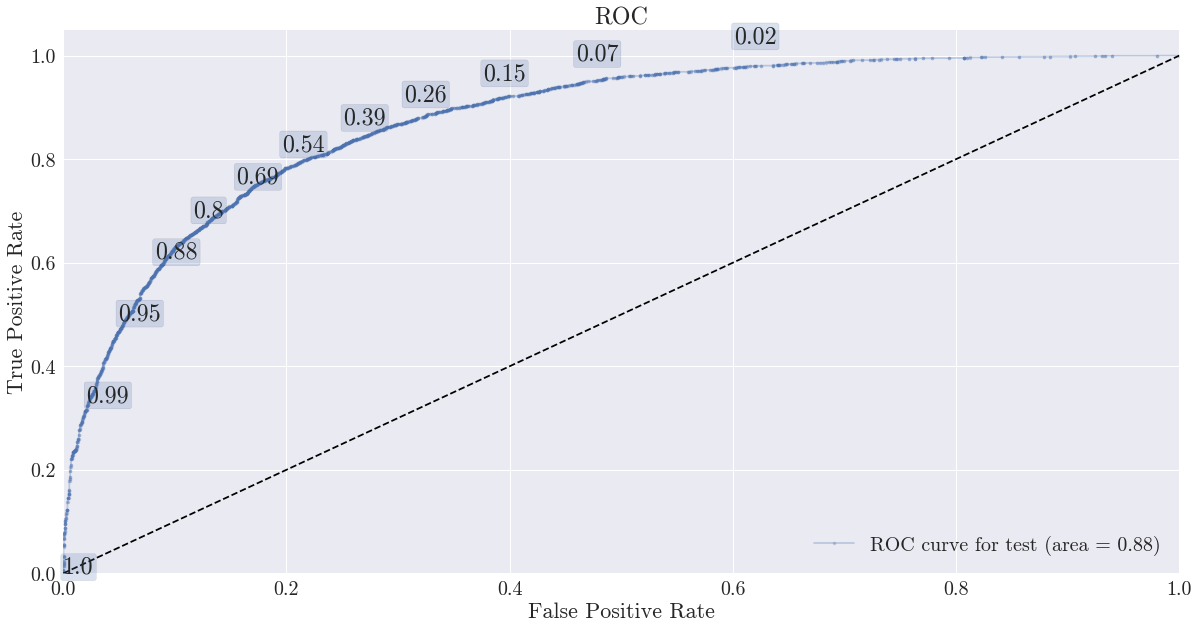

In [55]:
make_roc('test',clf,y_test,X_test)